# New Project Pivot:

Description: Weather app + predictors based on climate change history

My part: making visualizations based on previous weather data from Nasa API


In [41]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
import plotly.graph_objs as go
import matplotlib.dates as mdates
# ML libraries - idk which one to use yet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import cKDTree


In [32]:
import requests
import pandas as pd

def get_nasa_power_hourly_data(lat, lon, start_date, end_date, query_datetime=None):
    """
    Fetches hourly NASA POWER API data for a given latitude, longitude, and time range.
    Allows filtering by specific date and time.

    Args:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - start_date (str): Start date in YYYYMMDD format.
    - end_date (str): End date in YYYYMMDD format.
    - query_datetime (str, optional): Specific datetime to filter (format: "YYYY-MM-DD HH:00").

    Returns:
    - Pandas DataFrame with selected weather parameters.
    - If query_datetime is provided, returns only the row matching that datetime.
    """

    # Specify parameters to fetch
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M"

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"  # Change to hourly

    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        return None

    data = response.json()

    # Convert JSON response to DataFrame and transpose it
    nasa_weather = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T

    # Reset index and rename date column
    nasa_weather.reset_index(inplace=True)
    nasa_weather.rename(columns={"index": "datetime"}, inplace=True)

    # Convert datetime column to proper datetime format
    nasa_weather["datetime"] = pd.to_datetime(nasa_weather["datetime"], format="%Y%m%d%H", errors="coerce")
    nasa_weather.dropna(subset=["datetime"], inplace=True)  # Remove invalid date rows

    nasa_weather.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m"
    }, inplace=True)
    
    # Add Rounded_Lat and Rounded_Lng for merging
    nasa_weather['Rounded_Lat'] = lat
    nasa_weather['Rounded_Lng'] = lon

    # Convert units
    nasa_weather['Precipitation(in)'] = nasa_weather['Total_Precipitation_mm'] / 25.4  # mm to in
    nasa_weather['Temperature(F)'] = (nasa_weather['Temperature_2m_C'] * 9/5) + 32  # C to F
    nasa_weather['Wind_Speed(mph)'] = nasa_weather['Wind_Speed_2m'] * 2.237  # m/s to mph

    if query_datetime:
        query_datetime = pd.to_datetime(query_datetime, format="%Y-%m-%d %H:%M", errors="coerce")
        filtered_data = nasa_weather[nasa_weather["datetime"] == query_datetime]
        
        if filtered_data.empty:
            print(f"No data found for {query_datetime}. Try a different date/time within range.")
            return None
        
        print(f"\nWeather Data for {query_datetime} at Latitude {lat}, Longitude {lon}\n")
        return filtered_data

    print(f"\nHourly Weather Data for Latitude {lat}, Longitude {lon}\n")

    return nasa_weather


In [33]:
# Example: Fetch data for different locations
# by the day (hourly)
get_nasa_power_hourly_data(lat=37.7749, lon=-122.4194, start_date="20240225", end_date="20240226")


Hourly Weather Data for Latitude 37.7749, Longitude -122.4194



,datetime,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph)
0,2024-02-25 00:00:00,0.0,10.50,0.06,12.42,1.18,37.7749,-122.4194,0.002362,54.356,2.63966
1,2024-02-25 01:00:00,0.0,10.71,0.11,11.74,1.40,37.7749,-122.4194,0.004331,53.132,3.13180
2,2024-02-25 02:00:00,0.0,10.77,0.11,10.94,1.59,37.7749,-122.4194,0.004331,51.692,3.55683
3,2024-02-25 03:00:00,0.0,10.73,0.08,10.41,1.72,37.7749,-122.4194,0.003150,50.738,3.84764
4,2024-02-25 04:00:00,0.0,10.67,0.10,10.17,1.73,37.7749,-122.4194,0.003937,50.306,3.87001
5,2024-02-25 05:00:00,0.0,10.59,0.10,10.13,1.61,37.7749,-122.4194,0.003937,50.234,3.60157
6,2024-02-25 06:00:00,0.0,10.50,0.07,10.27,1.42,37.7749,-122.4194,0.002756,50.486,3.17654
7,2024-02-25 07:00:00,0.0,10.85,0.07,11.20,1.07,37.7749,-122.4194,0.002756,52.160,2.39359
8,2024-02-25 08:00:00,0.0,11.18,0.03,13.03,1.10,37.7749,-122.4194,0.001181,55.454,2.46070
9,2024-02-25 09:00:00,0.0,10.45,0.00,14.46,1.37,37.7749,-122.4194,0.000000,58.028,3.06469


In [34]:
# by specific hours
get_nasa_power_hourly_data(lat=37.7749, lon=-122.4194, start_date="20240225", end_date="20240226", query_datetime="2024-02-25 14:00")



Weather Data for 2024-02-25 14:00:00 at Latitude 37.7749, Longitude -122.4194



,datetime,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph)
14,2024-02-25 14:00:00,0.0,9.08,0.0,16.15,2.15,37.7749,-122.4194,0.0,61.07,4.80955


# Making visualizations

Ideas?
- general weather data (look at weather apps available)
- hourly + daily updates?
- data on each from past 10 years (mean of each year?)
- making a heat map based on surrounding area? (Temp + Precipitation)

In [97]:
def plot_hourly_temperature(df):
    """
    Plot temperature trends over time.
    Args:
        df: the dataframe from the NASA API call
    """
    fig = px.line(df, 
                  x="datetime", 
                  y="Temperature_2m_C", 
                  title="Hourly Temperature Trends",
                  labels={"datetime": "Datetime", "Temperature_2m_C": "Temperature (°C)"},
                  line_shape='linear', 
                  color_discrete_sequence=['red'])
    
    fig.update_layout(xaxis_title="Datetime", 
                      yaxis_title="Temperature (°C)", 
                      xaxis_tickangle=-45)
    fig.show()

In [101]:
def plot_hourly_precipitation(df):
    """
    Plot precipitation trends over time.
    Args:
        df: the dataframe from the NASA API call
    """
    fig = px.line(df, 
                  x="datetime", 
                  y="Total_Precipitation_mm", 
                  title="Hourly Precipitation Trends",
                  labels={"datetime": "Datetime", "Total_Precipitation_mm": "Total Precipitation (mm)"},
                  line_shape='linear', 
                  color_discrete_sequence=['blue'])
    
    fig.update_layout(xaxis_title="Datetime", 
                      yaxis_title="Precipitation (mm)", 
                      xaxis_tickangle=-45)
    fig.show()


In [103]:
def plot_hourly_wind_speed(df):
    """
    Plot wind speed trends over time.
    Args:
        df: the dataframe from the NASA API call
    """
    fig = px.line(df, 
                  x="datetime", 
                  y="Wind_Speed_2m", 
                  title="Hourly Wind Speed Trends",
                  labels={"datetime": "Datetime", "Wind_Speed_2m": "Wind Speed (m/s)"},
                  line_shape='linear', 
                  color_discrete_sequence=['blue'])
    
    fig.update_layout(xaxis_title="Datetime", 
                      yaxis_title="Wind Speed (m/s)", 
                      xaxis_tickangle=-45)
    fig.show()

In [104]:
def generate_all_visualizations(lat, lon, start_date, end_date):
    """
    Fetch data and generate all weather visualizations.
    Args:
        - lat (float): Latitude of the location.
        - lon (float): Longitude of the location.
        - start_date (str): Start date in YYYYMMDD format.
        - end_date (str): End date in YYYYMMDD format.
    """
    # plug in location and time into the NASA API call
    df = get_nasa_power_hourly_data(lat, lon, start_date, end_date)
    
    # if an error occurs, print out 'no data available'
    if df is None:
        print("No data available.")
        return
    
    # print out hourly updates for the day for temp, precipitation, and wind speed
    
    plot_hourly_temperature(df)
    plot_hourly_precipitation(df)
    plot_hourly_wind_speed(df)

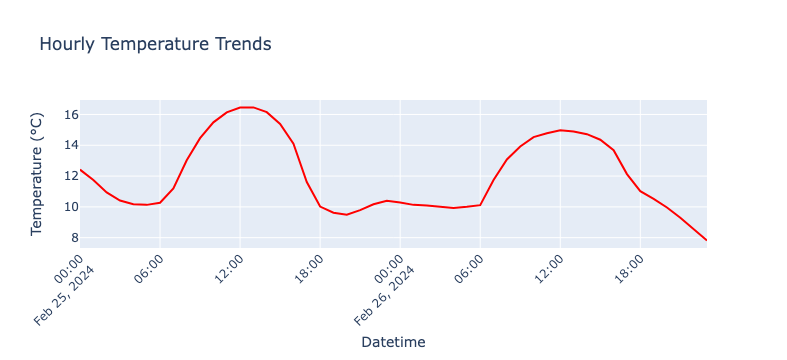

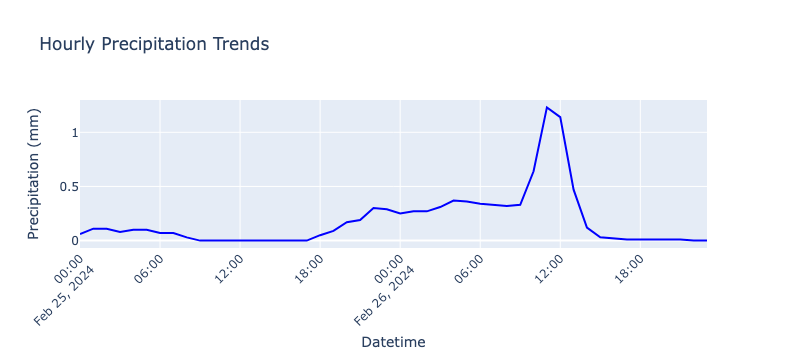

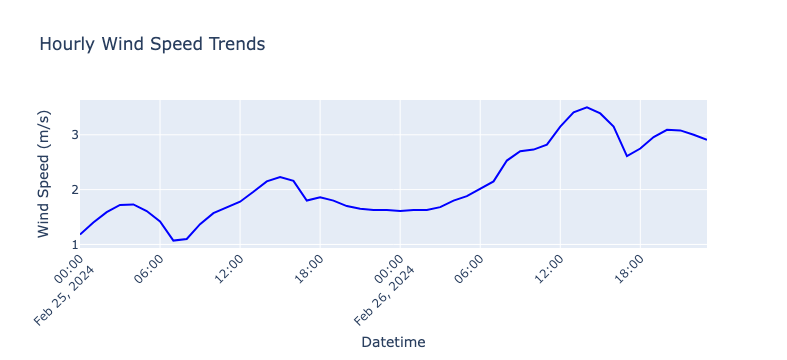

In [105]:
# testing visualization
generate_all_visualizations(lat=37.7749, 
                            lon=-122.4194, 
                            start_date="20240225", 
                            end_date="20240226")

In [83]:
def get_nasa_power_data_for_ten_years(lat, lon, start_year, end_year):
    """
    Fetches NASA POWER API hourly data for a ten-year period by splitting requests into two-year intervals.
    This is because it times out if you try to get too many years at one time
    """
    all_data = []
    for year in range(start_year, end_year, 2):
        start_date = f"{year}0101"
        end_date = f"{min(year + 1, end_year)}1231"
        print(f"Fetching data from {start_date} to {end_date}")
        df = get_nasa_power_hourly_data(lat, lon, start_date, end_date)
        if df is not None:
            all_data.append(df)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("No data retrieved for the specified range.")
        return None

# Example call for ten years of data
data_ten_years = get_nasa_power_data_for_ten_years(37.7749, -122.4194, 2014, 2024)


Fetching data from 20140101 to 20151231
Fetching data from 20160101 to 20171231
Fetching data from 20180101 to 20191231
Fetching data from 20200101 to 20211231
Fetching data from 20220101 to 20231231


In [82]:
data_ten_years.head()

,datetime,PRECSNO,T2MDEW,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m
0,2014-01-01 00:00:00,0.0,3.29,0.0,9.02,1.00
1,2014-01-01 01:00:00,0.0,3.26,0.0,8.88,0.91
2,2014-01-01 02:00:00,0.0,3.36,0.0,8.47,1.02
3,2014-01-01 03:00:00,0.0,3.34,0.0,8.09,1.23
4,2014-01-01 04:00:00,0.0,3.06,0.0,7.32,1.45


In [94]:
def plot_yearly_temperature(df):
    """
    Plot yearly mean temperature trends 
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Temperature_2m_C"].mean().reset_index()
    fig = px.bar(yearly_means,
                 x="year",
                 y="Temperature_2m_C",
                 color_discrete_sequence=["pink"],
                 title="Yearly Average Temperature Trends",
                 labels={"year": "Year", "Temperature_2m_C": "Mean Temperature (°C)"})
    fig.show()

def plot_yearly_precipitation(df):
    """
    Plot yearly mean precipitation trends.
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Total_Precipitation_mm"].mean().reset_index()
    fig = px.bar(yearly_means, x="year",
                 y="Total_Precipitation_mm",
                 color_discrete_sequence=["blue"],
                 title="Yearly Average Precipitation Trends",
                 labels={"year": "Year", "Total_Precipitation_mm": "Mean Precipitation (mm)"})
    fig.show()

def plot_yearly_wind_speed(df):
    """
    Plot yearly mean wind speed trends.
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Wind_Speed_2m"].mean().reset_index()
    fig = px.bar(yearly_means, 
                 x="year",
                 y="Wind_Speed_2m", 
                 color_discrete_sequence=["green"],
                 title="Yearly Average Wind Speed Trends", 
                 labels={"year": "Year", "Wind_Speed_2m": "Mean Wind Speed (m/s)"})
    fig.show()


In [95]:
def generate_all_visualizations_tenyears(lat, lon, start_year, end_year):
    """Fetch data for ten years and generate all weather visualizations."""
    df = get_nasa_power_data_for_ten_years(lat, lon, start_year, end_year)
    if df is None:
        print("No data available.")
        return
    plot_yearly_temperature(df)
    plot_yearly_precipitation(df)
    plot_yearly_wind_speed(df)

Fetching data from 20140101 to 20151231
Fetching data from 20160101 to 20171231
Fetching data from 20180101 to 20191231
Fetching data from 20200101 to 20211231
Fetching data from 20220101 to 20231231


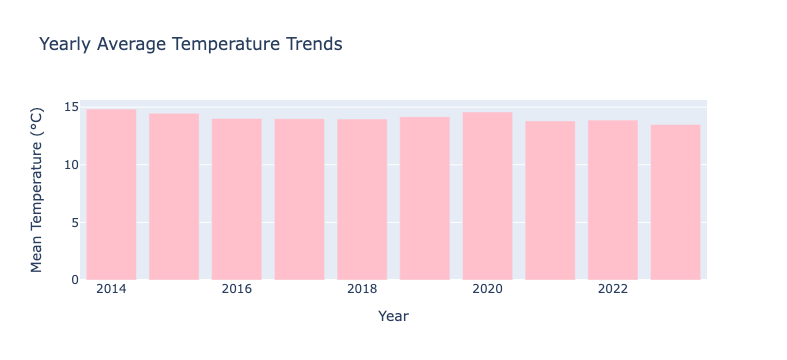

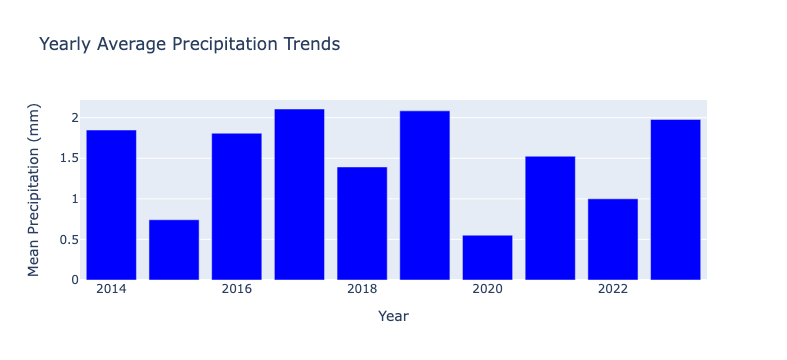

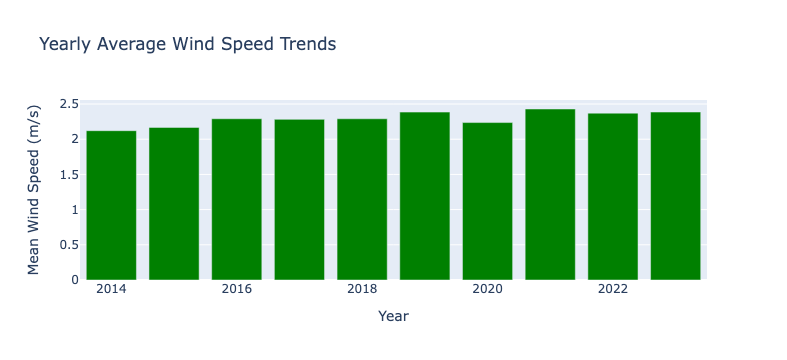

In [96]:
generate_all_visualizations_tenyears(37.7749, -122.4194, 2014, 2024)